# Comparison of different noise models

Saikat Banerjee  
2023-08-02

Denoising can be done either using Gaussian noise or sparse noise or
both. Here, I compare the three noise models.

# About

Our goal is to obtain a denoised, low-rank approximation of the input
matrix. Such low-rank matrix can be obtained using different noise
models:

1.  **Gaussian noise** $$
    \min_{\mathbf{X}} \frac{1}{2}\left\lVert \mathbf{Y} - \mathbf{X} \right\rVert_{F}^2 \quad \textrm{s.t.} \quad \left\lVert \mathbf{X} \right\rVert_{*} \le r
    $$
2.  **Sparse noise** $$
    \min_{\mathbf{X}, \mathbf{M}} \left\lVert \mathbf{X} \right\rVert_{*} + \lambda \left\lVert \mathbf{M} \right\rVert_{1} \quad \textrm{s.t.} \quad \mathbf{L} + \mathbf{M} = \mathbf{Y}
    $$
3.  **Gaussian + sparse** $$
    \min_{\mathbf{X}} \frac{1}{2}\left\lVert \mathbf{Y} - \mathbf{X} - \mathbf{M} \right\rVert_{F}^2 \quad \textrm{s.t.} \quad \left\lVert \mathbf{X} \right\rVert_{*} \le r_L\,, \left\lVert \mathbf{M} \right\rVert_{1} \le r_M
    $$

For models (1) and (3), we use the Frank-Wolfe method, and for model
(2), we use the inexact augmented Lagrangian method (IALM) with a slight
modification of the step-size update (borrowing the ADMM updates of Boyd
et. al.). We use a simple simulation (as described previously) with
additive Gaussian noise to realistically mimic the z-scores obtained
from multiple GWAS.

# Getting setup

We have now implemented a Python software to call the different methods
with flexibility to choose different input options.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe
from nnwmf.utils import model_errors as merr

# Simulation

In [2]:
ntrait = 4 # categories / class
ngwas  = 500 # N
nsnp   = 1000 # P
nfctr  = 40 # K

In [29]:
Y, Y_true, L, F, mean, noise_var, sample_indices = mpy_simulate.simulate(ngwas, nsnp, ntrait, nfctr, std = 1.5, do_shift_mean = False)
Y_cent = mpy_simulate.do_standardize(Y, scale = False)
Y_std  = mpy_simulate.do_standardize(Y)
Y_true_cent = mpy_simulate.do_standardize(Y_true, scale = False)

In [30]:
unique_labels  = list(range(len(sample_indices)))
class_labels = [None for x in range(ngwas)]
for k, idxs in enumerate(sample_indices):
    for i in idxs:
        class_labels[i] = k

In [Figure 1](#fig-loadings-covariance-simulation), we show the
underlying structure of our simulated data. On the left panel, we show
the covariance of the true loadings and on the right panel, we show the
covariance of the observed data (strong noise removes the underlying
correlation)

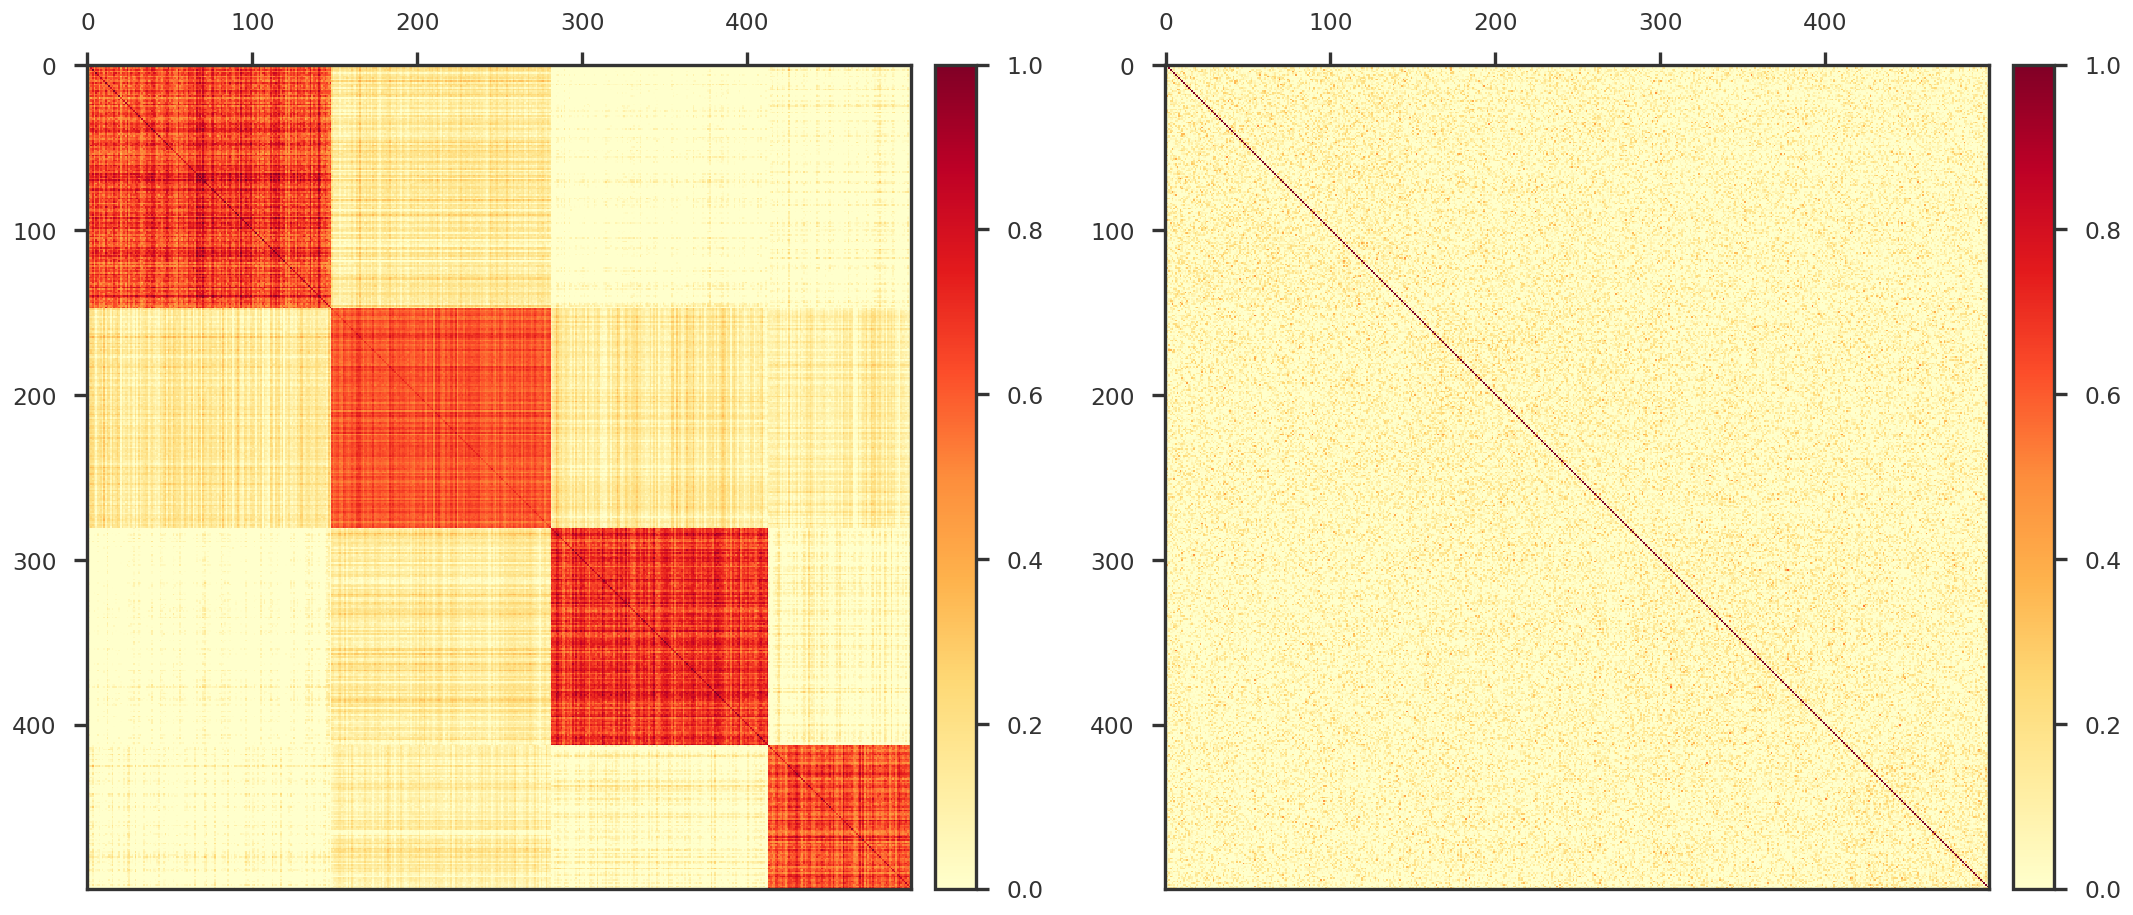

In [48]:
fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mpy_plotfn.plot_covariance_heatmap(ax1, L)
mpy_plotfn.plot_covariance_heatmap(ax2, Y)

plt.tight_layout(w_pad = 2.0)
plt.show()

# Denoising Methods

We then apply the three methods.

## IALM - RPCA

In [32]:
rpca = IALM(benchmark = True, max_iter = 1000, mu_update_method='admm', show_progress = True)
rpca.fit(Y_cent, Xtrue = Y_cent)

2023-08-02 14:46:55,016 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 0. Primal residual 0.807755. Dual residual 0.00319521
2023-08-02 14:47:16,524 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 100. Primal residual 6.9408e-06. Dual residual 1.68576e-06

## FW - NNM

We do a little cheating here. Instead of cross-validation, we directly
use the known rank of the underlying true data. However, based on my
previous work, I know that cross-validation does provide the correct
rank.

In [33]:
nnm = FrankWolfe(model = 'nnm', svd_max_iter = 50, 
                 show_progress = True, debug = True, benchmark = True)
nnm.fit(Y_cent, 40.0, Ytrue = Y_cent)

2023-08-02 14:47:37,144 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 5383.02

## FW - NNML1

For the third model, we use the sparse noise threshold from the RPCA
result and the rank from the true data. I have not checked
cross-validation results for this method yet.

In [49]:
np.sum(np.abs(rpca.E_)) / (ngwas * nsnp)

0.7012888342395619

In [37]:
nnm_sparse = FrankWolfe(model = 'nnm-sparse', max_iter = 1000, svd_max_iter = 50, 
                        tol = 1e-3, step_tol = 1e-5, simplex_method = 'sort',
                        show_progress = True, debug = True, benchmark = True, print_skip = 100)
nnm_sparse.fit(Y_cent, (40.0, 0.7), Ytrue = Y_cent)

2023-08-02 14:47:49,393 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 6.42438e+06
2023-08-02 14:48:03,988 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 100. Step size 0.004. Duality Gap 6.28097

# Results

## CPU time and accuracy

In [Figure 2](#fig-rmse-vs-time), we look at the RMSE (w.r.t the
observed input data) and CPU time.

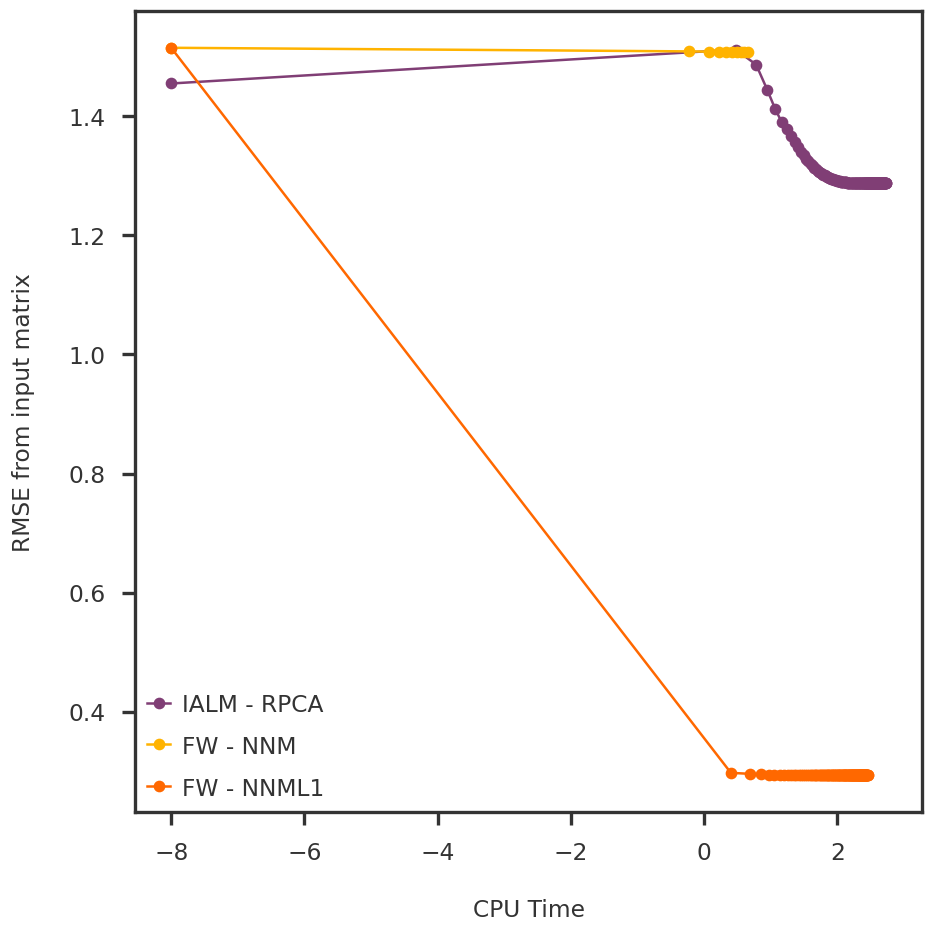

In [38]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

kp = 0
ax1.plot(np.log10(np.cumsum(rpca.cpu_time_[kp:])), rpca.rmse_[kp:], 'o-', label = 'IALM - RPCA')
ax1.plot(np.log10(np.cumsum(nnm.cpu_time_[kp:])), nnm.rmse_[kp:], 'o-', label = 'FW - NNM')
ax1.plot(np.log10(np.cumsum(nnm_sparse.cpu_time_[kp:])), nnm_sparse.rmse_[kp:], 'o-', label = 'FW - NNML1')
ax1.legend()

ax1.set_xlabel("CPU Time")
ax1.set_ylabel("RMSE from input matrix")

plt.tight_layout(w_pad = 2.0)
plt.show()

## Principal Components

Can the principal components of the low rank matrix help in
classification?

In [39]:
def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    return pcomps

pcomps_rpca = get_principal_components(rpca.L_)
pcomps_nnm = get_principal_components(nnm.X)
pcomps_nnm_sparse = get_principal_components(nnm_sparse.X)

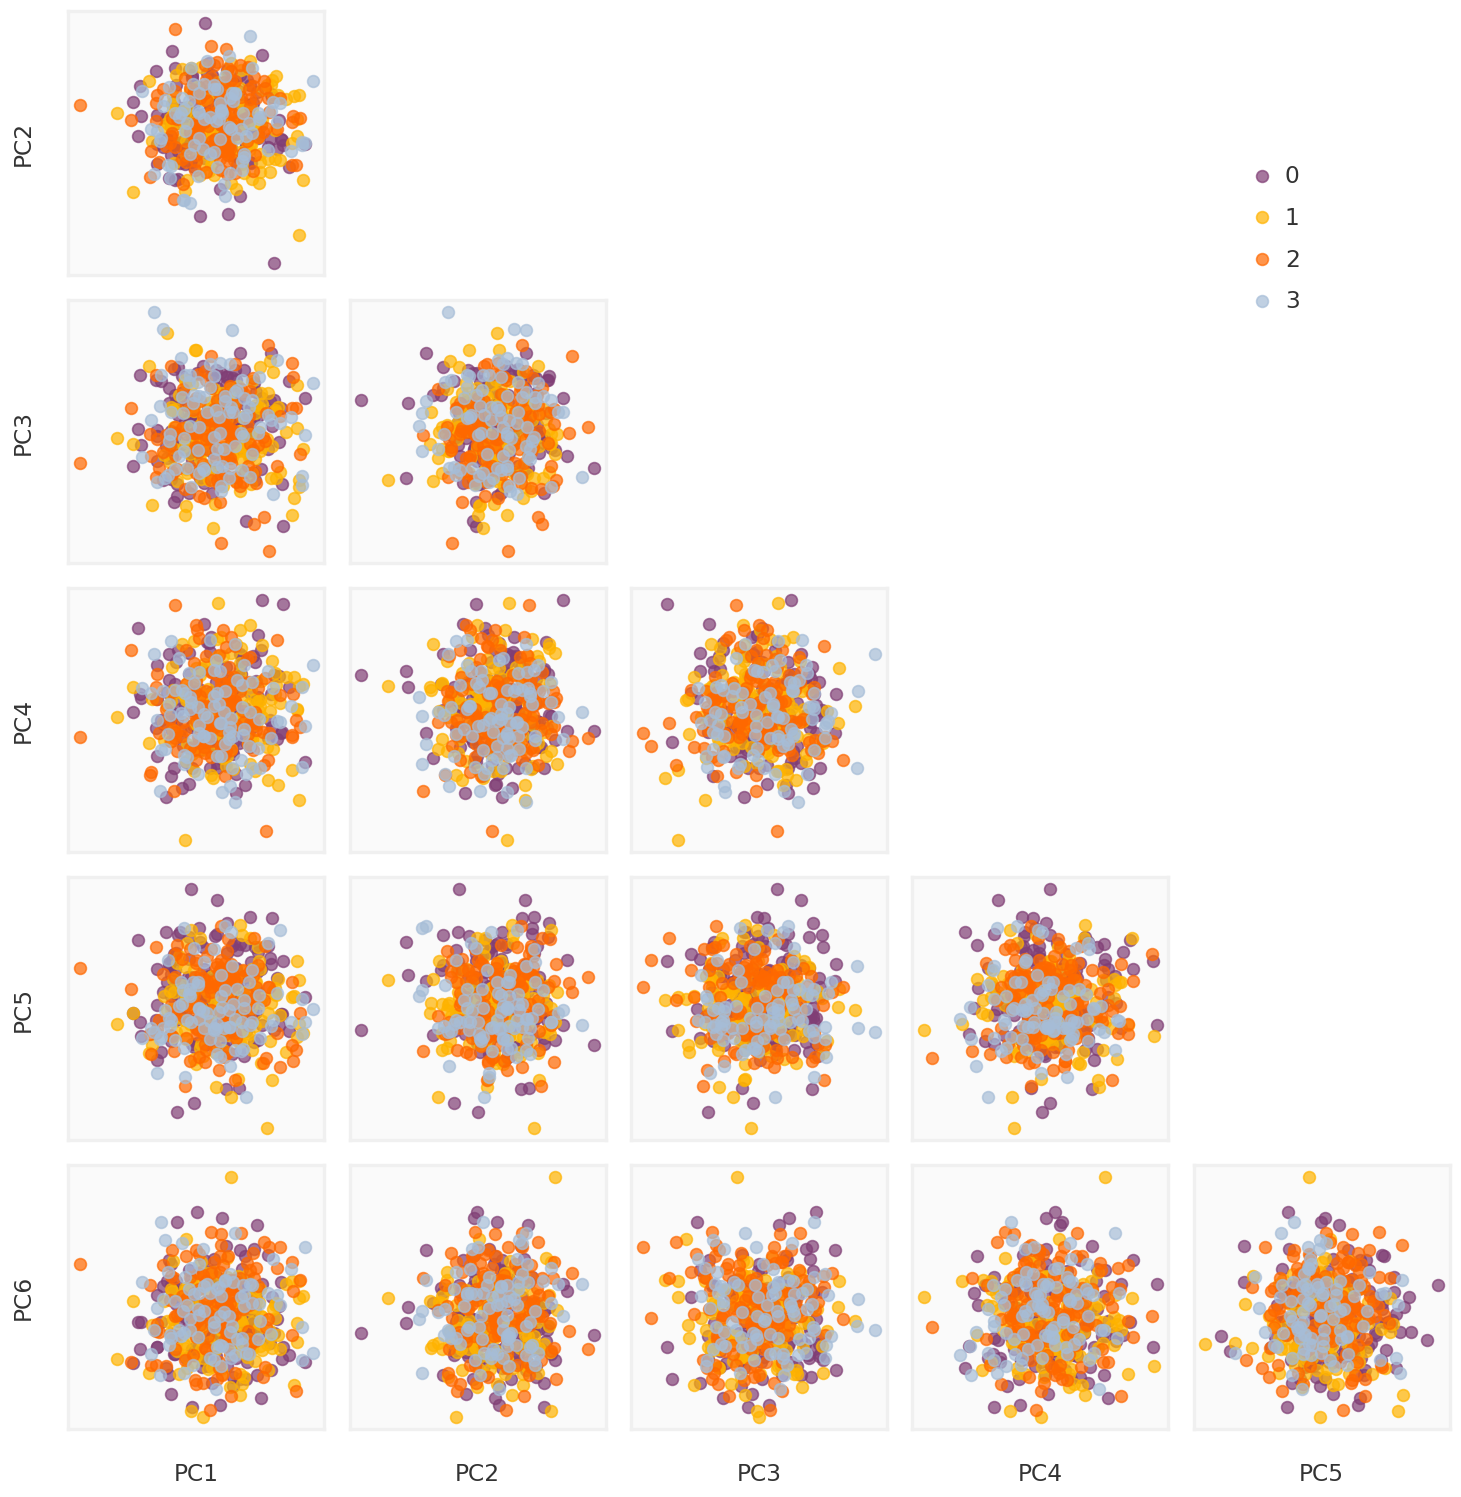

In [50]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_nnm, class_labels, unique_labels)
plt.show()

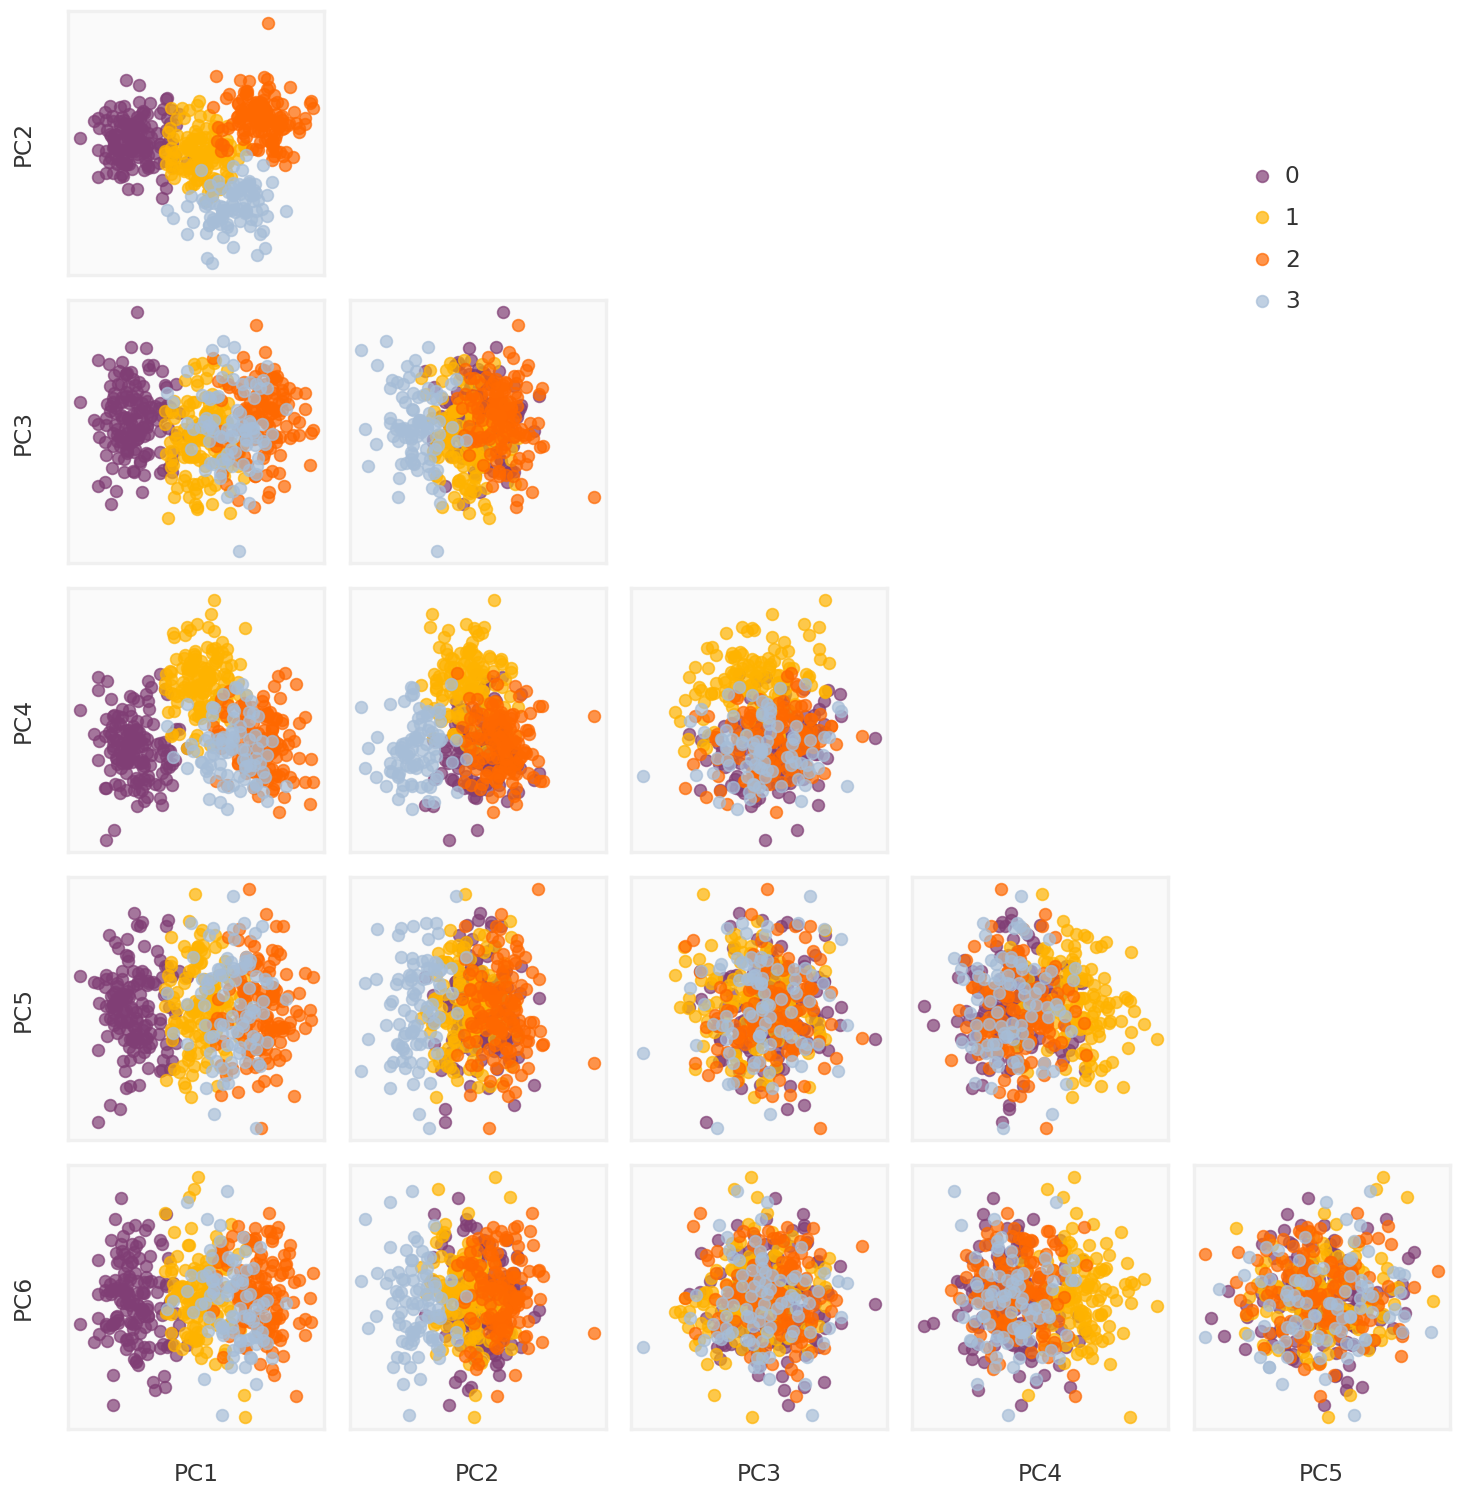

In [51]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca, class_labels, unique_labels)
plt.show()

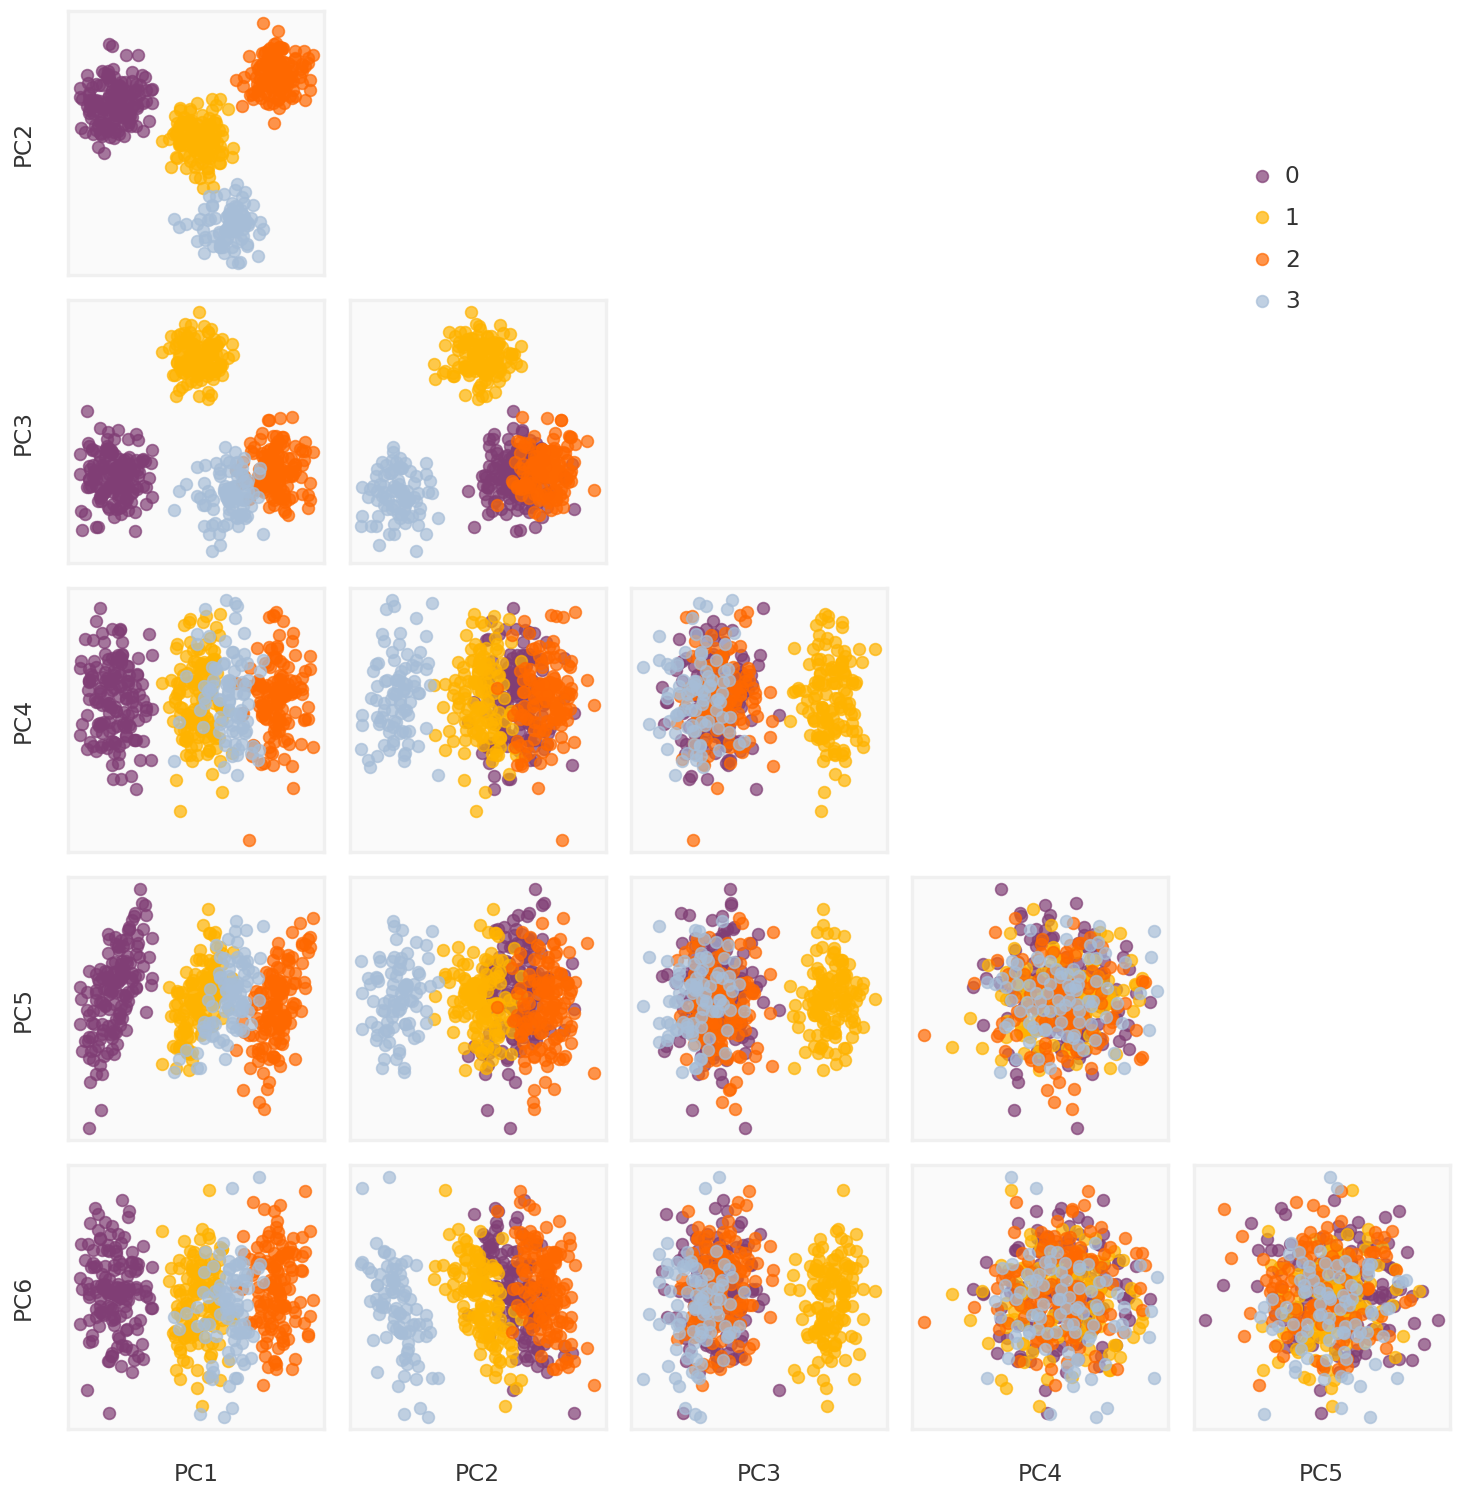

In [52]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_nnm_sparse, class_labels, unique_labels)
plt.show()

## Benchmark stats

We look at different statistics to determine the efficiency of the
methods. In particular:

1.  **RMSE** (root mean square error) with respect to the ground truth
2.  **PSNR** (peak signal-to-noise-ratio) with respect to the ground
    truth (frequently used in image denoising literature)
3.  **Adjusted MI score** measures how good the methods are in the
    classification task.

In [53]:
Y_true_cent = mpy_simulate.do_standardize(Y_true, scale = False)
Y_rpca_cent = mpy_simulate.do_standardize(rpca.L_, scale = False)
Y_nnm_cent  = mpy_simulate.do_standardize(nnm.X, scale = False)
Y_nnm_sparse_cent = mpy_simulate.do_standardize(nnm_sparse.X, scale = False)

## RMSE

In [54]:
rmse_rpca = merr.get(Y_true_cent, Y_rpca_cent, method = 'rmse')
rmse_nnm = merr.get(Y_true_cent, Y_nnm_cent, method = 'rmse')
rmse_nnm_sparse = merr.get(Y_true_cent, Y_nnm_sparse_cent, method = 'rmse')

print (f"{rmse_nnm:.4f}\tNuclear Norm Minimization")
print (f"{rmse_nnm_sparse:.4f}\tSparse Nuclear Norm Minimization")
print (f"{rmse_rpca:.4f}\tRobust PCA")

0.1602  Nuclear Norm Minimization
0.1371  Sparse Nuclear Norm Minimization
0.3972  Robust PCA

## PSNR

In [55]:
psnr_rpca = merr.get(Y_true_cent, Y_rpca_cent, method = 'psnr')
psnr_nnm = merr.get(Y_true_cent, Y_nnm_cent, method = 'psnr')
psnr_nnm_sparse = merr.get(Y_true_cent, Y_nnm_sparse_cent, method = 'psnr')

print (f"{psnr_nnm:.4f}\tNuclear Norm Minimization")
print (f"{psnr_nnm_sparse:.4f}\tSparse Nuclear Norm Minimization")
print (f"{psnr_rpca:.4f}\tRobust PCA")

19.6846 Nuclear Norm Minimization
21.0394 Sparse Nuclear Norm Minimization
11.7991 Robust PCA

## Adjusted MI Score

In [46]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics as skmetrics

def get_adjusted_MI_score(pcomp, class_labels):
    distance_matrix = skmetrics.pairwise.pairwise_distances(pcomp, metric='euclidean')
    model = AgglomerativeClustering(n_clusters = 4, linkage = 'average', metric = 'precomputed')
    class_pred = model.fit_predict(distance_matrix)
    return skmetrics.adjusted_mutual_info_score(class_labels, class_pred)

adjusted_mi_nnm = get_adjusted_MI_score(pcomps_nnm,   class_labels)
adjusted_mi_nnm_sparse = get_adjusted_MI_score(pcomps_nnm_sparse, class_labels)
adjusted_mi_rpca = get_adjusted_MI_score(pcomps_rpca, class_labels)

print (f"{adjusted_mi_nnm:.4f}\tNuclear Norm Minimization")
print (f"{adjusted_mi_nnm_sparse:.4f}\tSparse Nuclear Norm Minimization")
print (f"{adjusted_mi_rpca:.4f}\tRobust PCA")

-0.0011 Nuclear Norm Minimization
1.0000  Sparse Nuclear Norm Minimization
0.0099  Robust PCA